# Residual Networks Implementation with Keras

Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow us to train much deeper networks than were previously practically feasible.

- Implement the basic building blocks of ResNets. 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 


In [2]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

## 1 - The problem of very deep neural networks

The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the lower layers) to very complex features (at the deeper layers). However, a huge barrier to training them is vanishing gradients.

<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Vanishing gradient** <br> The speed of learning decreases very rapidly for the early layers as the network trains </center></caption>


## 2 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : A ResNet block showing a **skip-connection** <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

ResNet makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance. 

Two main types of blocks are used in a ResNet, depending mainly on **whether the input/output dimensions are same or different**.

### 2.1 - The identity block
 

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers.</center></caption>

Here're the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Final step: 
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 


In [3]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. we'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

## 2.2 - The convolutional block

Next, the ResNet "convolutional block" is the other type of block, use it when **the input and output dimensions don't match up**. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Convolutional block** </center></caption>

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '2a'`. 
- The first BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.
- The second BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.
- The third BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.
- The BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '1'`. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 


In [5]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',  padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1',  padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

## 3 - Building ResNet model (50 layers)

"ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The flatten doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.


In [7]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3,  [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3,  [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3,  [256,256,1024], stage=4, block='d')
    X = identity_block(X, 3,  [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3,  [256,256,1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, filters = [512,512,2048], stage = 5, block='b')
    X = identity_block(X, 3, filters = [512,512,2048], stage = 5, block='c')
    X = identity_block(X, 3, filters = [512,512,2048], stage = 5, block='d')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(2,2)(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [8]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Let's load the SIGNS Dataset.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 6** </u><font color='purple'>  : **SIGNS dataset** </center></caption>


In [10]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [21]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
1080/1080 [==============================] - 72s 66ms/step - loss: 0.6094 - acc: 0.8333
Epoch 2/20
1080/1080 [==============================] - 69s 64ms/step - loss: 0.2020 - acc: 0.9472
Epoch 3/20
1080/1080 [==============================] - 66s 61ms/step - loss: 0.2035 - acc: 0.9352
Epoch 4/20
1080/1080 [==============================] - 67s 62ms/step - loss: 0.1207 - acc: 0.9667
Epoch 5/20
1080/1080 [==============================] - 67s 62ms/step - loss: 0.2399 - acc: 0.9370
Epoch 6/20
1080/1080 [==============================] - 69s 64ms/step - loss: 0.0844 - acc: 0.9759
Epoch 7/20
1080/1080 [==============================] - 72s 67ms/step - loss: 0.0832 - acc: 0.9676
Epoch 8/20
1080/1080 [==============================] - 69s 64ms/step - loss: 0.1746 - acc: 0.9519
Epoch 9/20
1080/1080 [==============================] - 72s 67ms/step - loss: 0.1256 - acc: 0.9583
Epoch 10/20
1080/1080 [==============================] - 66s 61ms/step - loss: 0.0714 - acc: 0.9731
Epoch 11/

Let's see how this model (trained on only two epochs) performs on the test set.

In [22]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 2s 18ms/step
Loss = 1.8497828245162964
Test Accuracy = 0.650000003973643


ResNet50 is a powerful model for image classification when it is trained for an adequate number of iterations.

## 4 - Test on your own image (Optional/Ungraded)

If you wish, you can also take a picture of your own hand and see the output of the model. To do this:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right! 

In [12]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

You can also print a summary of your model by running the following code.

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Finally, run the code below to visualize your ResNet50. You can also download a .png picture of your model by going to "File -> Open...-> model.png".

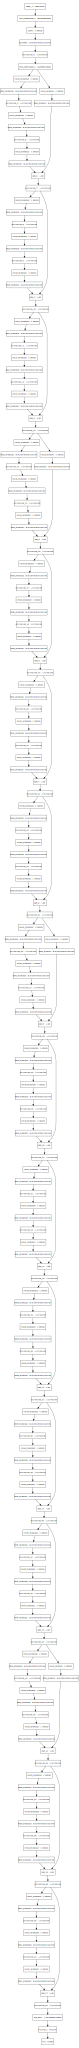

In [20]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the github repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's github repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
